In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output

from fenics import *
from algorithms.matrix_free_rsvd import MatrixFreeRSVD, get_approximate_W, tikhonov_solver
from utils.mesh_utils import get_square_f
from utils.colors import C2, C3, C5, CMAP
from scipy.sparse import diags

import importlib
import algorithms.weighted_low_rank_solver
importlib.reload(algorithms.weighted_low_rank_solver)
from algorithms.weighted_low_rank_solver import WeightedLowRankSolver

SEED = 15

/home/elias/miniforge3/envs/fenics_env/lib/python3.9/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


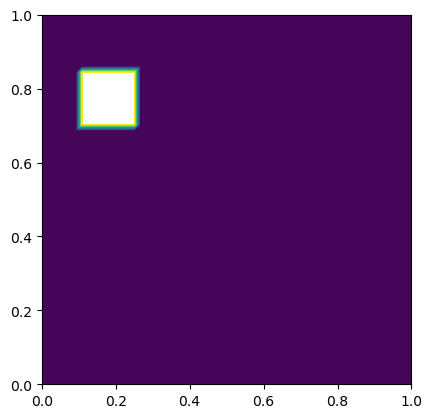

In [2]:
mesh = UnitSquareMesh(64, 64)
V_h = FunctionSpace(mesh, 'CG', 1)

# Source parameters
x0, y0, width, height = 0.1, 0.7, 0.15, 0.15
rsvd = MatrixFreeRSVD(V_h)
f = get_square_f(V_h, x0, y0, w=width, h=height)
x = f.vector().get_local()
y = rsvd.apply_K(x)

plot(f);

In [3]:
k_low, k_upper = 5, 40
k_range = np.arange(k_low, k_upper)
nk = len(k_range)

repeats = 50

errors_tikhonov       = np.zeros((repeats, nk))
errors_adam           = np.zeros((repeats, nk))
errors_adam_projected = np.zeros((repeats, nk))
errors_TV             = np.zeros((repeats, nk))
errors_TV_projected   = np.zeros((repeats, nk))

rng = np.random.default_rng(SEED)
for r in range(repeats):
    seed = rng.integers(low=0, high=1e7)

    for i, k in enumerate(k_range):
        clear_output()
        print(f"Repeat {r+1}/{repeats}, rank {i+1}/{nk}")

        U, S, VT = rsvd.mf_rsvd(k=k, seed=seed)
        w = get_approximate_W(VT.T, rsvd.M_dx)
        x_tikhonov = tikhonov_solver(rsvd=rsvd, W_diag=w, y=y, lambda_=1e-3)

        solver = WeightedLowRankSolver(
            V_h=V_h, M_dx=rsvd.M_dx, M_ds=rsvd.M_ds,
            U=U, S=S, VT=VT
        )
        f_adam = solver.solve_adam(y,
            r_s=1,
            w=w,
            lambda_=1e-4,
            seed=seed,
            tol=1e-4,
        )
        f_adam_projected = solver.solve_adam(y,
            r_s=1,
            w=w,
            lambda_=1e-4,
            seed=seed,
            tol=1e-4,
            projection=True
        )
        f_TV = solver.solve_TV(y,
            r_s=1,
            w=w,
            lambda_=1e-4,  # regularization param
            max_iter=2000,
            beta=5e-8,
            seed=seed,
            projection=False
        )
        f_TV_projected = solver.solve_TV(y,
            r_s=1,
            w=w,
            lambda_=1e-4,  # regularization param
            max_iter=2000,
            beta=5e-8,
            seed=seed,
            projection=True
        )
        
        x_adam           = f_adam.vector().get_local()
        x_adam_projected = f_adam_projected.vector().get_local()
        x_TV             = f_TV.vector().get_local()
        x_TV_projected   = f_TV_projected.vector().get_local()

        errors_tikhonov[r, i]       = np.linalg.norm(x - x_tikhonov)
        errors_adam[r, i]           = np.linalg.norm(x - x_adam)
        errors_adam_projected[r, i] = np.linalg.norm(x - x_adam_projected)
        errors_TV[r, i]             = np.linalg.norm(x - x_TV)
        errors_TV_projected[r, i]   = np.linalg.norm(x - x_TV_projected)


Repeat 50/50, rank 35/35
[##############################] 5000/5000 (dX=3.7e-02)

Returning lowest error solution (iteration 477)
[######                        ] 1125/5000 (dX=9.1e-05)
Converged at iteration 1125
Returning lowest error solution (iteration 1125)
[#########################     ] 1675/2000 (dX=9.8e-05)
Converged at iteration 1675
Returning lowest error solution (iteration 864)
[################              ] 1100/2000 (dX=9.7e-05)
Converged at iteration 1100
Returning lowest error solution (iteration 1100)


In [4]:
file_name = f'../results/07_errors_k_{k_low}_{k_upper}_r_{repeats}.npz'
if not os.path.exists(file_name):
    errors = {
        "Weighted": errors_tikhonov,
        "Adam": errors_adam,
        "Adam Proj": errors_adam_projected,
        "TV": errors_TV,
        "TV Proj": errors_TV_projected
    }
    print(f"Saving results as {file_name}")
    np.savez(file_name, **errors)

# Compute the mean value 
errors = np.load(file_name)
means = {method: np.mean(e, axis=0) for method, e in errors.items()}

Saving results as ../results/07_errors_k_5_40_r_50.npz


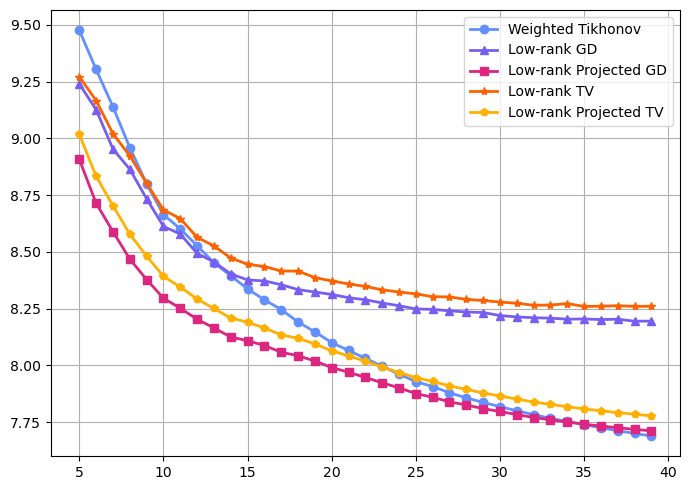

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(k_range, means["Weighted"],  label='Weighted Tikhonov',     c=C5[0], lw=2, marker='o')
ax.plot(k_range, means["Adam"],      label='Low-rank GD',           c=C5[1], lw=2, marker='^')
ax.plot(k_range, means["Adam Proj"], label='Low-rank Projected GD',           c=C5[2], lw=2, marker='s')
ax.plot(k_range, means["TV"],        label='Low-rank TV',           c=C5[3], lw=2, marker='*')
ax.plot(k_range, means["TV Proj"],   label='Low-rank Projected TV', c=C5[4], lw=2, marker='p')

ax.legend()
ax.grid(0.5)

plt.tight_layout()
plt.show()

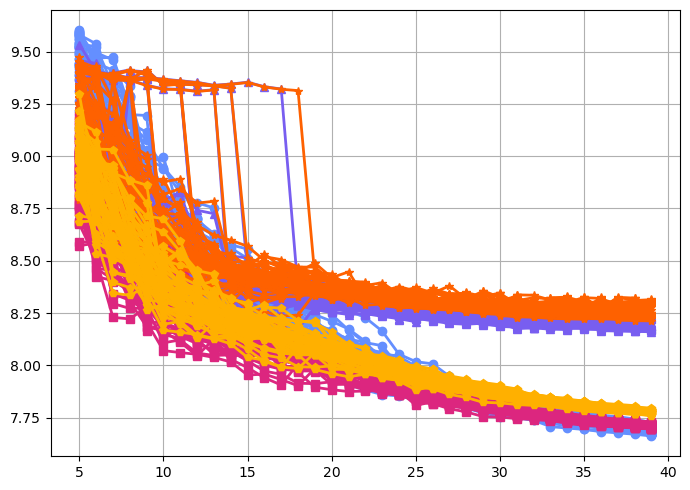

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(k_range, errors["Weighted"].T,  label='Weighted Tikhonov',     c=C5[0], lw=2, marker='o')
ax.plot(k_range, errors["Adam"].T,      label='Low-rank GD',           c=C5[1], lw=2, marker='^')
ax.plot(k_range, errors["Adam Proj"].T, label='Low-rank Projected GD', c=C5[2], lw=2, marker='s')
ax.plot(k_range, errors["TV"].T,        label='Low-rank TV',           c=C5[3], lw=2, marker='*')
ax.plot(k_range, errors["TV Proj"].T,   label='Low-rank Projected TV', c=C5[4], lw=2, marker='p')

#ax.legend()
ax.grid(0.5)

plt.tight_layout()
plt.show()